In [33]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
import matplotlib.pyplot as plt

In [10]:
df = pd.read_csv('/content/airline-passengers.csv')

In [11]:
df.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


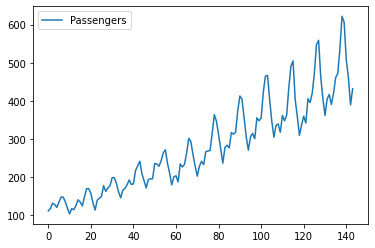

In [12]:
df.plot()

In [15]:
le = preprocessing.LabelEncoder()

In [16]:
year = pd.DatetimeIndex(df['Month']).year
year_series = np.array(year)
year_series = le.fit_transform(year_series)

In [17]:
month = pd.DatetimeIndex(df['Month']).month
month_series = np.array(month)
month_series = le.fit_transform(month_series)

In [68]:
df_new = pd.concat([pd.Series(year_series),pd.Series(month_series),df['Passengers']],axis=1)
df_new.head()

,0,1,Passengers
0,0,0,112
1,0,1,118
2,0,2,132
3,0,3,129
4,0,4,121


In [29]:
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df_new)

features = data_scaled
target = data_scaled[:, -1]

print(features.shape)
print(target.shape)

(144, 3)
(144,)


In [32]:
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.20, random_state=123, shuffle=False)

print(x_train.shape)
print(y_train.shape)

print(x_test.shape)
print(y_test.shape)

(115, 3)
(115,)
(29, 3)
(29,)


In [34]:
win_length = 12
batch_size = 16
num_features = 3
train_generator = TimeseriesGenerator(x_train, y_train, length=win_length, sampling_rate=1, batch_size=batch_size)
test_generator = TimeseriesGenerator(x_test, y_test, length=win_length, sampling_rate=1, batch_size=batch_size)

In [38]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [80]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(win_length, num_features)))
model.add(Dense(4))
model.compile(optimizer='adam', loss='mse')

In [81]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 100)               41600     
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 404       
Total params: 42,004
Trainable params: 42,004
Non-trainable params: 0
_________________________________________________________________


In [82]:
model.compile(loss=tf.losses.MeanSquaredError(),
              optimizer=tf.optimizers.Adam(),
              metrics=[tf.metrics.MeanAbsoluteError()])

history = model.fit_generator(train_generator, epochs=50,
                              validation_data=test_generator,
                              shuffle=False)


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
7/7 [==============================] - 2s 60ms/step - loss: 0.0615 - mean_absolute_error: 0.2049 - val_loss: 0.2573 - val_mean_absolute_error: 0.4801
Epoch 2/50
7/7 [==============================] - 0s 21ms/step - loss: 0.0207 - mean_absolute_error: 0.1052 - val_loss: 0.0817 - val_mean_absolute_error: 0.2380
Epoch 3/50
7/7 [==============================] - 0s 20ms/step - loss: 0.0130 - mean_absolute_error: 0.0986 - val_loss: 0.0254 - val_mean_absolute_error: 0.1232
Epoch 4/50
7/7 [==============================] - 0s 17ms/step - loss: 0.0176 - mean_absolute_error: 0.1139 - val_loss: 0.0407 - val_mean_absolute_error: 0.1490
Epoch 5/50
7/7 [==============================] - 0s 16ms/step - loss: 0.0131 - mean_absolute_error: 0.0908 - val_loss: 0.0475 - val_mean_absolute_error: 0.1645
Epoch 6/50
7/7 [==============================] - 0s 16ms/step - loss: 0.0095 - mean_absolute_error: 0.0766 - val_loss: 0.0295 - val_mean_absolute_error: 0.1264
Epoch 7/50
7/7 [==================

In [83]:
last_train_batch = data_scaled[-win_length:]

In [84]:
last_train_batch = last_train_batch.reshape((1, win_length, num_features))

In [85]:
model.predict(last_train_batch)

array([[0.58798987, 0.56485534, 0.58611107, 0.5849282 ]], dtype=float32)

In [86]:
y_test[0:4]

array([0.77413127, 0.57915058, 0.49227799, 0.3976834 ])